## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [11]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
SAVE_BEST_ONLY=[True,False]

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512 

50000/50000 [==============================] - 10s 192us/step - loss: 0.5761 - accuracy: 0.8297 - val_loss: 1.5820 - val_accuracy: 0.4992
Epoch 46/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.5560 - accuracy: 0.8373 - val_loss: 1.6219 - val_accuracy: 0.5021
Epoch 47/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.5411 - accuracy: 0.8435 - val_loss: 1.6286 - val_accuracy: 0.4933
Epoch 48/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.5221 - accuracy: 0.8507 - val_loss: 1.6316 - val_accuracy: 0.4997
Epoch 49/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.5060 - accuracy: 0.8587 - val_loss: 1.6541 - val_accuracy: 0.4912
Epoch 50/50
10000/10000 [==============================] - 2s 178us/step

loss_loadback: 1.445083787727356 acc_loadback: 0.49559998512268066



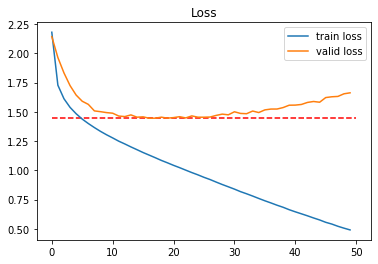

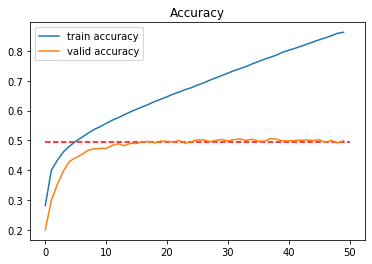

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512 

50000/50000 [==============================] - 10s 193us/step - loss: 0.5828 - accuracy: 0.8266 - val_loss: 1.6281 - val_accuracy: 0.4867
Epoch 46/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.5655 - accuracy: 0.8340 - val_loss: 1.6320 - val_accuracy: 0.4945
Epoch 47/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.5487 - accuracy: 0.8408 - val_loss: 1.6481 - val_accuracy: 0.4871
Epoch 48/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.5307 - accuracy: 0.8475 - val_loss: 1.6538 - val_accuracy: 0.4850
Epoch 49/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.5168 - accuracy: 0.8533 - val_loss: 1.6606 - val_accuracy: 0.4895
Epoch 50/50
10000/10000 [==============================] - 2s 208us/step

loss_loadback: 1.7075649625778198 acc_loadback: 0.4851999878883362



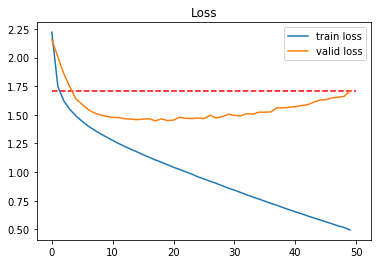

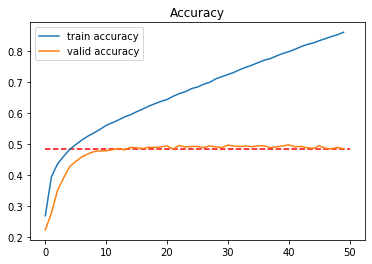

In [21]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, save_best_only設true,flase看差別
"""
from keras.callbacks import ModelCheckpoint

results = {}
for i in SAVE_BEST_ONLY:
    model_ckpt = ModelCheckpoint(filepath='./tmp_{}'.format(i)+'.h5', 
                             monitor="val_loss", 
                             verbose=0,
                             save_best_only=i)

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    # Load back
    model = keras.models.load_model('./tmp_{}'.format(i)+'.h5')
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
    print()
    print('loss_loadback:',loss_loadback, 'acc_loadback:',acc_loadback)
    print()
    
    plt.plot(range(len(train_loss)), train_loss, label="train loss")
    plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
    plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
    plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
    plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

### 儲存模型：前面的內容已經提過
### 載回模型
- 儲存整個模型的話 ---> keras.models.load_model(path_to_your_model)
- 只儲存權重的話 ---> model = build_model(...)-> model.load_weights(path_to_your_weight_file)
